# 🌟 AURA - Multi-Task Learning for Cross-Domain Toxicity Detection

**AURA** = **A**ffective **U**nderstanding for **R**obust **A**buse Detection

---
## ⚠️ PRIMA DI ESEGUIRE:
1. **Settings** (⚙️) → **Accelerator** → **GPU T4 x2**
2. **Add Input** → Carica `aura-data` (deve contenere `goemotions_processed.csv` e `olid_train.csv`)
---

## 1️⃣ Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch.optim.lr_scheduler import OneCycleLR
from transformers import BertModel, BertTokenizer
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
import json
import os
import warnings
warnings.filterwarnings('ignore')

print("="*50)
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("❌ NO GPU! Vai su Settings → Accelerator → GPU T4")
    raise RuntimeError("Attiva la GPU prima di procedere!")
print("="*50)

torch.manual_seed(42)
np.random.seed(42)

2026-01-09 17:22:00.505304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767979320.730271      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767979320.794357      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767979321.358564      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767979321.358596      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767979321.358599      24 computation_placer.cc:177] computation placer alr

✅ GPU: Tesla T4


In [2]:
CONFIG = {
    'encoder': 'bert-base-uncased',
    'max_length': 128,
    'num_emotion_classes': 7,
    'dropout': 0.1,
    'batch_size': 16,
    'gradient_accumulation': 2,
    'epochs': 8,
    'lr_bert': 2e-5,
    'lr_heads': 1e-4,
    'weight_decay': 0.01,
    'patience': 3,
    'focal_gamma': 2.0,
    'output_dir': '/kaggle/working'
}

DATA_DIR = None
for path in ['/kaggle/input/aura-data', '/kaggle/input/aura-data/kaggle_upload', 'data/processed']:
    if os.path.exists(path) and 'olid_train.csv' in os.listdir(path):
        DATA_DIR = path
        break

if DATA_DIR is None:
    raise FileNotFoundError("Dataset non trovato! Assicurati di aver collegato 'aura-data'.")

print(f"✅ Dataset trovato: {DATA_DIR}")

✅ Dataset trovato: /kaggle/input/aura-data


## 2️⃣ Model Architectures (Theoretical Alignment)

In [3]:
class AURA(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.bert = BertModel.from_pretrained(config['encoder'])
        hidden_size = self.bert.config.hidden_size
        self.dropout = nn.Dropout(config['dropout'])
        self.toxicity_head = nn.Linear(hidden_size, 2)
        self.emotion_head = nn.Linear(hidden_size, config['num_emotion_classes'])
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.dropout(outputs.pooler_output)
        return self.toxicity_head(pooled), self.emotion_head(pooled)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        return (((1 - pt) ** self.gamma) * ce_loss).mean()

class UncertaintyLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.log_vars = nn.Parameter(torch.zeros(2))
        
    def forward(self, loss_tox, loss_emo):
        p1 = torch.exp(-self.log_vars[0])
        p2 = torch.exp(-self.log_vars[1])
        return p1 * loss_tox + self.log_vars[0] + p2 * loss_emo + self.log_vars[1]

def load_weights(path):
    if os.path.exists(path):
        with open(path) as f:
            data = json.load(f)
            return torch.tensor(data.get('weights', [1.0]*7), dtype=torch.float32)
    return torch.ones(7)

## 3️⃣ Multitask Dataset Handler

In [4]:
class AURADataset(Dataset):
    def __init__(self, csv_path, tokenizer, max_length, is_toxicity=True):
        self.df = pd.read_csv(csv_path)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_toxicity = is_toxicity
        self.emo_cols = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = str(row.get('text', row.get('tweet', '')))
        enc = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_length,
            padding='max_length', truncation=True, return_tensors='pt'
        )
        tox_label = -1
        emo_label = torch.full((7,), -1.0)
        if self.is_toxicity:
            label_raw = row['label'] if 'label' in row else row.get('subtask_a', 'NOT')
            tox_label = 1 if label_raw in [1, 'OFF'] else 0
        else:
            emo_label = torch.tensor([float(row[c]) for c in self.emo_cols], dtype=torch.float32)
        return {
            'input_ids': enc['input_ids'].flatten(),
            'attention_mask': enc['attention_mask'].flatten(),
            'toxicity_target': torch.tensor(tox_label, dtype=torch.long),
            'emotion_target': emo_label
        }

tokenizer = BertTokenizer.from_pretrained(CONFIG['encoder'])
olid_train = AURADataset(f"{DATA_DIR}/olid_train.csv", tokenizer, CONFIG['max_length'], is_toxicity=True)
olid_val = AURADataset(f"{DATA_DIR}/olid_validation.csv", tokenizer, CONFIG['max_length'], is_toxicity=True)
goemo_full = AURADataset(f"{DATA_DIR}/goemotions_processed.csv", tokenizer, CONFIG['max_length'], is_toxicity=False)
indices = np.random.choice(len(goemo_full), 30000, replace=False)
goemo_subset = torch.utils.data.Subset(goemo_full, indices)
train_set = ConcatDataset([olid_train, goemo_subset])
train_loader = DataLoader(train_set, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(olid_val, batch_size=CONFIG['batch_size'], num_workers=2)
print(f"✅ Training set: {len(train_set)} samples")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

✅ Training set: 41916 samples


## 4️⃣ MTL Training Loop

In [5]:
from torch.cuda.amp import GradScaler, autocast
model = AURA(CONFIG).to(device)
uncertainty_loss = UncertaintyLoss().to(device)
focal_loss = FocalLoss(CONFIG['focal_gamma']).to(device)
scaler = GradScaler()
optimizer = optim.AdamW([
    {'params': model.bert.parameters(), 'lr': CONFIG['lr_bert']},
    {'params': model.toxicity_head.parameters(), 'lr': CONFIG['lr_heads']},
    {'params': model.emotion_head.parameters(), 'lr': CONFIG['lr_heads']},
    {'params': uncertainty_loss.parameters(), 'lr': CONFIG['lr_heads']}
], weight_decay=CONFIG['weight_decay'])
emo_weights = load_weights(f"{DATA_DIR}/class_weights.json").to(device)
criterion_emo = nn.BCEWithLogitsLoss(pos_weight=emo_weights)
total_steps = len(train_loader) * CONFIG['epochs'] // CONFIG['gradient_accumulation']
scheduler = OneCycleLR(optimizer, max_lr=[CONFIG['lr_bert'], CONFIG['lr_heads'], CONFIG['lr_heads'], CONFIG['lr_heads']], total_steps=total_steps, pct_start=0.1)

def train_step(batch, i):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    tox_targets = batch['toxicity_target'].to(device)
    emo_targets = batch['emotion_target'].to(device)
    with autocast():
        tox_logits, emo_logits = model(input_ids, attention_mask)
        tox_mask = tox_targets != -1
        loss_tox = focal_loss(tox_logits[tox_mask], tox_targets[tox_mask]) if tox_mask.sum() > 0 else torch.tensor(0.0, device=device)
        emo_mask = emo_targets[:, 0] != -1
        loss_emo = criterion_emo(emo_logits[emo_mask], emo_targets[emo_mask]) if emo_mask.sum() > 0 else torch.tensor(0.0, device=device)
        loss = (uncertainty_loss(loss_tox, loss_emo)) / CONFIG['gradient_accumulation']
    scaler.scale(loss).backward()
    if (i + 1) % CONFIG['gradient_accumulation'] == 0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        optimizer.zero_grad()
    return loss.item() * CONFIG['gradient_accumulation']

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [6]:
best_f1 = 0
patience = 0
for epoch in range(1, CONFIG['epochs'] + 1):
    model.train()
    total_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for i, batch in enumerate(pbar):
        loss = train_step(batch, i)
        total_loss += loss
        if i % 100 == 0: pbar.set_postfix({'loss': f'{loss:.4f}'})
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            tox_logits, _ = model(batch['input_ids'].to(device), batch['attention_mask'].to(device))
            preds.extend(torch.argmax(tox_logits, dim=1).cpu().numpy())
            labels.extend(batch['toxicity_target'].cpu().numpy())
    val_f1 = f1_score(labels, preds, average='macro', zero_division=0)
    print(f"Epoch {epoch}: Avg Loss={total_loss/len(train_loader):.4f}, Val F1={val_f1:.4f}")
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "aura_mtl_best.pt")
        patience = 0
    else:
        patience += 1
        if patience >= CONFIG['patience']: break

Epoch 1:   0%|          | 0/2620 [00:00<?, ?it/s]

Epoch 1: Avg Loss=0.4183, Val F1=0.7731


Epoch 2:   0%|          | 0/2620 [00:00<?, ?it/s]

Epoch 2: Avg Loss=0.0719, Val F1=0.7692


Epoch 3:   0%|          | 0/2620 [00:00<?, ?it/s]

Epoch 3: Avg Loss=-0.1952, Val F1=0.7558


Epoch 4:   0%|          | 0/2620 [00:00<?, ?it/s]

Epoch 4: Avg Loss=-0.4467, Val F1=0.7480


## 5️⃣ Stress Testing (Cross-Domain Robustness)

In [7]:
model.load_state_dict(torch.load("aura_mtl_best.pt"))
model.eval()
class StressDataset(Dataset):
    def __init__(self, path, tokenizer):
        if path.endswith('.json'):
            with open(path) as f: self.data = json.load(f)
        else:
            self.data = pd.read_csv(path).to_dict('records')
        self.tokenizer = tokenizer
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        item = self.data[idx]
        text = str(item.get('text', item.get('tweet', '')))
        label_raw = item.get('label', item.get('subtask_a', 'NOT'))
        label = 1 if label_raw in ['OFF', 1] else 0
        enc = self.tokenizer.encode_plus(text, max_length=128, padding='max_length', truncation=True, return_tensors='pt')
        return {'ids': enc['input_ids'].flatten(), 'mask': enc['attention_mask'].flatten(), 'label': label}
def stress_test(name, path):
    ds = StressDataset(path, tokenizer)
    dl = DataLoader(ds, batch_size=32)
    preds, labels = [], []
    for batch in dl:
        with torch.no_grad():
            logits, _ = model(batch['ids'].to(device), batch['mask'].to(device))
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            labels.extend(batch['label'].numpy())
    f1 = f1_score(labels, preds, average='macro', zero_division=0)
    print(f"🎯 {name}: Macro-F1 = {f1:.4f}")
    return f1
f1_l1 = stress_test("Level 1 (OLID)", f"{DATA_DIR}/olid_test.csv")
f1_l2 = stress_test("Level 2 (Jigsaw)", f"{DATA_DIR}/jigsaw_test.json")
f1_l3 = stress_test("Level 3 (ToxiGen)", f"{DATA_DIR}/toxigen_test.json")
print(f"\n🚀 Cross-Domain Delta (ΔF1): {f1_l1 - f1_l3:.4f}")

🎯 Level 1 (OLID): Macro-F1 = 0.7917
🎯 Level 2 (Jigsaw): Macro-F1 = 0.7744
🎯 Level 3 (ToxiGen): Macro-F1 = 0.5168

🚀 Cross-Domain Delta (ΔF1): 0.2749


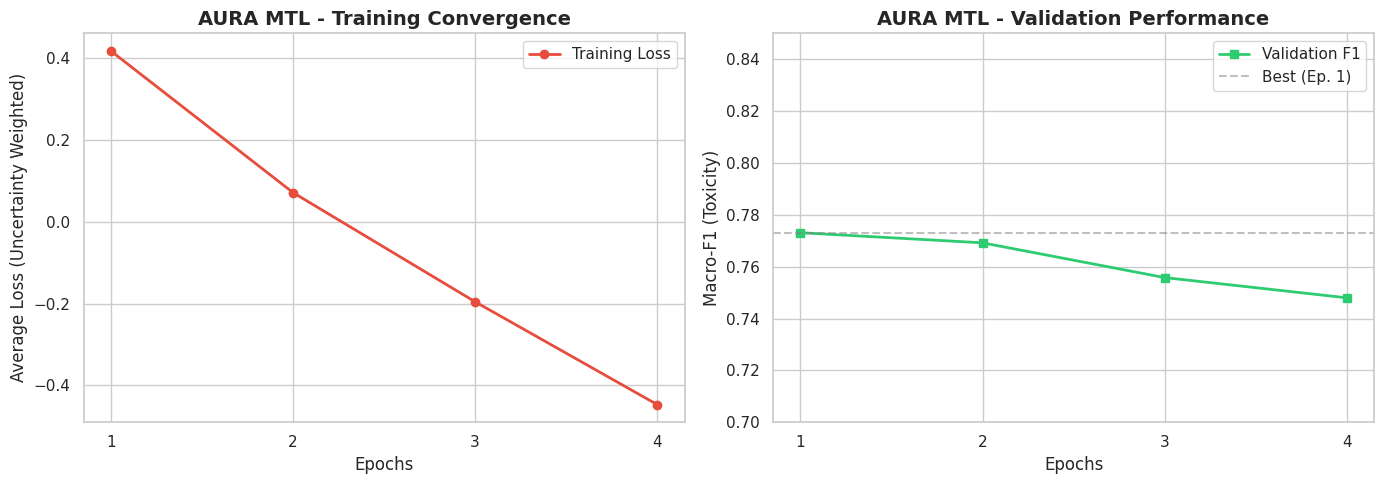

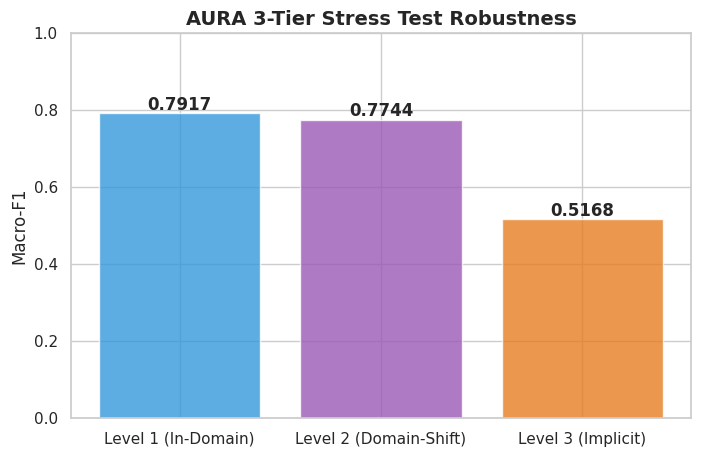

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dati del tuo training
epochs = [1, 2, 3, 4]
avg_loss = [0.4183, 0.0719, -0.1952, -0.4467]
val_f1 = [0.7731, 0.7692, 0.7558, 0.7480]

# Setup estetico
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 5))

# 1. Grafico della Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, avg_loss, marker='o', color='#e74c3c', linewidth=2, label='Training Loss')
plt.title('AURA MTL - Training Convergence', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Average Loss (Uncertainty Weighted)', fontsize=12)
plt.xticks(epochs)
plt.legend()

# 2. Grafico della Macro-F1
plt.subplot(1, 2, 2)
plt.plot(epochs, val_f1, marker='s', color='#2ecc71', linewidth=2, label='Validation F1')
plt.axhline(y=0.7731, color='gray', linestyle='--', alpha=0.5, label='Best (Ep. 1)')
plt.title('AURA MTL - Validation Performance', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Macro-F1 (Toxicity)', fontsize=12)
plt.xticks(epochs)
plt.ylim(0.70, 0.85)
plt.legend()

plt.tight_layout()
plt.savefig('aura_training_curves.png', dpi=300) # Lo salva anche come file
plt.show()

# 3. Grafico Stress Test (Bar Chart)
plt.figure(figsize=(8, 5))
levels = ['Level 1 (In-Domain)', 'Level 2 (Domain-Shift)', 'Level 3 (Implicit)']
scores = [0.7917, 0.7744, 0.5168]
colors = ['#3498db', '#9b59b6', '#e67e22']

plt.bar(levels, scores, color=colors, alpha=0.8)
for i, v in enumerate(scores):
    plt.text(i, v + 0.01, str(v), ha='center', fontweight='bold')
    
plt.title('AURA 3-Tier Stress Test Robustness', fontsize=14, fontweight='bold')
plt.ylabel('Macro-F1', fontsize=12)
plt.ylim(0, 1.0)
plt.savefig('aura_stress_test.png', dpi=300)
plt.show()